# PRETRAIN FROM PERSONALLY TRAINED MODEL
## FastAI Cassava Root Disease Classification

In [1]:
RUN_NAME_OF_MODEL_TO_LOAD = f'20210208-2112 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=40 bs=8 res=380'
EPOCH_TO_LOAD = 0

<br>
<br>

In [2]:
from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from string import ascii_uppercase
import numpy as np
import operator
import glob


# %matplotlib inline

%matplotlib widget

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')


ARCH = 'tf_efficientnet_b4_ns'  # resnet101

CHOSEN_SAMPLE_SIZE = 1800  # use this to control per-category sample sizes # 1000  # deprecated but not removed
# TEST_SET_SIZE = round(CHOSEN_SAMPLE_SIZE * 0.1)  # number of images per category to put in the test set
FROZEN_EPOCHS = 1  # 1
EPOCHS = 40  # 4
BATCH_SIZE = 7  # 16
RESOLUTION = round(380 * 1.3)  # 300
PRETRAINED_FLAG = True

# data = ''
# rn_addon = f'_data={data}'

time = datetime.today().strftime("%Y%m%d-%H%M")

# RUN_NAME = f'{time} - arch={ARCH.__name__} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'
RUN_NAME = f'{time} - arch={ARCH} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'

print(f"RUN_NAME = '{RUN_NAME}'")


RUN_NAME = '20210209-0146 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=40 bs=7 res=494'


In [3]:
import torch
print('CUDA available: '.ljust(28), torch.cuda.is_available())
print('CUDA device count: '.ljust(28), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device index: '.ljust(28), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(28), torch.cuda.get_device_name(current_device))
print()
# print('CUDA available: '.ljust(24), torch.cuda.is_available())
print(f'fastai version:              {fastai.__version__}')
# print(f'fastcore version:            {fastcore.__version__}')
# print(f'fastbook version:            {fastbook.__version__}')
print(f'cuda version:                {torch.version.cuda}')
print(f'torch version:               {torch.__version__}')
# print(f'python version:              {python_version()}')

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER

fastai version:              2.2.2
cuda version:                11.0
torch version:               1.7.0


<br>
<br>

## Utillity Functions



In [4]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=False, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model


def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

<br>
<br>

### Check for Imbalance

In [5]:
classes = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

In [6]:
path = '../data/train_images_sorted'

img_flist = {}
img_quants = {}

for c in classes:
    files = get_image_files(f'{path}/{c}')
    img_flist[c] = list(files)
    img_quants[c] = len(files)

minqc = min(img_quants, key=img_quants.get)

sample_size = round(img_quants[minqc] * 2.5)  # oversample the lowest class quantity


plt.figure(figsize=(6,3))
plt.bar(img_quants.keys(), img_quants.values())  
plt.axhline(sample_size, ls='--', color='red', label='Chosen Sample Size')
plt.legend()
plt.show()
        

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:

for c in classes:
    if len(img_flist[c]) < sample_size:
#         all_covid = img_flist[c].copy()
        img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], sample_size - len(img_flist[c]), replace=True))
    else:
        img_flist[c] = np.random.choice(img_flist[c], sample_size, replace=False)  # without replacement

    # boost the weak class
    if c == 'healthy':
        img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], round(sample_size * 0.5), replace=False))
        
plt.figure(figsize=(6,3))
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
test_flist = {}
test_size = round(0.1 * sample_size)

for c in classes:
    img_flist[c] = np.random.choice(img_flist[c], len(img_flist[c]), replace=False)  # shuffle
    test_flist[c] = img_flist[c][0:test_size]
    img_flist[c] = img_flist[c][test_size:]
#     img_flist[c] = [f for f in img_flist[c] if f not in test_flist[c]]

In [9]:
plt.figure(figsize=(6,3))
plt.title('Training Data')
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.axhline(test_size, ls='--', color='red')
plt.show()

plt.figure(figsize=(6,3))
plt.title('Validation Data')
plt.bar(test_flist.keys(), [len(l) for l in test_flist.values()])
plt.show()
                 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
def get_fnames(path):
    retlist = []
    
    for l in img_flist.values():
        for f in l:
            retlist.append(f)
            
    return random.sample(retlist, len(retlist))

# batch_tfms = [ *aug_transforms(size=round(RESOLUTION * 1), do_flip=True, batch=True, max_zoom=1.7, mult=2.4), Normalize.from_stats(*imagenet_stats) ]
batch_tfms = [ *aug_transforms(size=round(RESOLUTION * 1), do_flip=True, batch=True, max_zoom=1.2, mult=2.8), Normalize.from_stats(*imagenet_stats) ]


img_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.28, seed=42),
    get_y=parent_label,
#     item_tfms=Resize(RESOLUTION, method='bilinear') , batch_tfms=batch_tfms)
    item_tfms=RandomResizedCrop(RESOLUTION) , batch_tfms=batch_tfms)

dls = img_db.dataloaders(path, batch_size=BATCH_SIZE)

<br>

### Verify the Training and Validation Batches

In [11]:
dls.valid.show_batch(max_n=16, nrows=4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
# Eary stopping callback
early_stop_cb = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0001, patience=5)

# Save the current model's weights every epoch
save_cb = SaveModelCallback(fname=RUN_NAME, every_epoch=True, with_opt=True)

# Reduce the Learning Rate if valid_loss flatlines
reduceLR_cb = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, min_lr=1e-8, patience=3)

# Mixup callback for regularization
# mixup_cb = MixUp(alpha=0.4)
mixup_cb = None

# Cutmix callback for regularization
cutmix_cb = CutMix(alpha=0.3)
# cutmix_cb = None




# List of callbacks to be used later
cbs = [ShowGraphCallback(), save_cb, GradientAccumulation(n_acc=32), reduceLR_cb]

if mixup_cb != None:
    cbs.insert(0, mixup_cb)
    
if cutmix_cb != None:
    cbs.insert(0, cutmix_cb)




print('\nAll Callbacks: ', cbs)


All Callbacks:  [CutMix, ShowGraphCallback, SaveModelCallback, GradientAccumulation, ReduceLROnPlateau]


### Visualize the effect of CutMix


In [13]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
    
else: print('\n CutMix was not selected.')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

In [14]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')


 MixUp was not selected.


In [15]:
# learn = cnn_learner(dls, ARCH , 
#                     pretrained=PRETRAINED_FLAG, wd=1e-4, opt_func=ranger,
#                     loss_func=LabelSmoothingCrossEntropyFlat(), 
#                     cbs = cbs, metrics=[error_rate, accuracy])

# from wwf.vision.timm import *
import timm
learn = timm_learner(dls, 
                    'tf_efficientnet_b4_ns',
                     opt_func=ranger,
                     loss_func=LabelSmoothingCrossEntropy(),
                     cbs=cbs,
                     metrics = [accuracy]).to_fp16()

In [16]:
# Add custom weights to learn

# learn = load_learner(f'../models/{RUN_NAME_OF_MODEL_TO_LOAD}.pkl', cpu=False)
load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)


In [17]:
display(learn.loss_func, learn.opt_func, learn.cbs)

LabelSmoothingCrossEntropy()

<function fastai.optimizer.ranger(p, lr, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)>

(#9) [TrainEvalCallback,Recorder,ProgressCallback,CutMix,ShowGraphCallback,SaveModelCallback,GradientAccumulation,ReduceLROnPlateau,MixedPrecision]

<br>
<br>
<br>

## Find a Good Learning Rate to Start With

In [18]:
LR_DIV = 14e0  # Shift the lr_min left by this amount.  Adjust as necessary
lr_min = 0.002  # just a default

In [19]:
if PRETRAINED_FLAG == True:
    learn.freeze()
    lr_min,lr_steep = learn.lr_find()
    plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
    plt.axvline(lr_min/LR_DIV, ls='--', color='yellow', label=f'lr_min / {LR_DIV}={round(lr_min/LR_DIV,6)}')
    plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
    plt.legend()
    plt.show()

    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, (Mim/10)/{LR_DIV}: {lr_min/LR_DIV}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Minimum/10: 1.10e-07, steepest point: 7.59e-07, (Mim/10)/14.0: 7.831986944698396e-09


<br>
<br>

# Pick a Good Initial Learning Rate

In [20]:
# LR_CHOICE = lr_min/LR_DIV
# LR_CHOICE = lr_steep
# LR_CHOICE = 8e-5
LR_CHOICE = 2e-4

<br>
<br>

<br>
<br>

# Training the Model

<br>

## Fit the last layers, unfreeze, fit the whole net, with a decent initial LR, all in one go.



FROZEN_EPOCHS:  1
EPOCHS:         40
Learning Rate:  0.0002




epoch,train_loss,valid_loss,accuracy,time
0,1.226851,0.736670,0.833333,18:58


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

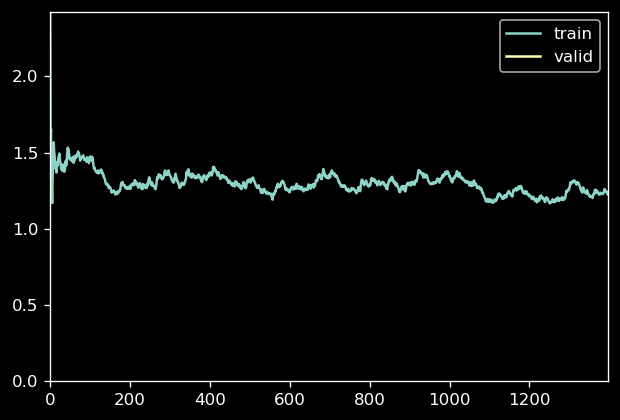

In [21]:


if PRETRAINED_FLAG:
    print(f'FROZEN_EPOCHS:  {FROZEN_EPOCHS}')
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE}\n\n')

if PRETRAINED_FLAG:
    learn.fit_flat_cos(FROZEN_EPOCHS, slice(LR_CHOICE), pct_start=0.99, wd=0.1)


## Manually set up the unfrozen runs

In [22]:
learn.unfreeze()

In [ ]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, LR_CHOICE/2: {LR_CHOICE / 2}")

## Pick a new Learning Rate

In [ ]:
# LR_CHOICE_UNFROZ = lr_min/LR_DIV
# LR_CHOICE_UNFROZ = LR_CHOICE / 2
# LR_CHOICE_UNFROZ = 0.00015
# LR_CHOICE_UNFROZ = 10e-5
# LR_CHOICE_UNFROZ = 0.00008
# LR_CHOICE_UNFROZ = 5.5e-5
# LR_CHOICE_UNFROZ = 1.7e-4
# LR_CHOICE_UNFROZ = 6e-5
# LR_CHOICE_UNFROZ = lr_min
LR_CHOICE_UNFROZ = 1e-3

### Train

In [ ]:
EPOCHS = 10

In [ ]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

In [ ]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)
learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.5)

<br>
<br>

## Persist the Model

In [ ]:
learn.export(f'../models/{RUN_NAME}.pkl')
# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

In [ ]:
learn.show_results()

<br>
<hr>
<br>
<br>
<br>

# Validation Set (not test set) Analysis

<br>

### Plot Losses

In [ ]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

<br>

### Visualize with a confusion Matrix

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>

### Show the top 15 most error prone images

In [ ]:
interp.plot_top_losses(15, nrows=5)

## Validation

In [ ]:
test_learn = learn

# load_learner('../models/20210205-1716 - arch=xresnet34 - samples=1800 frozen=1 epochs=40 bs=32 res=340.pkl', cpu=False)
# load_model(f'models/{RUN_NAME}_26.pth', test_learn, opt=Adam, with_opt=False)


In [ ]:
def get_test_fnames(path):
    retlist = []
    
    for l in test_flist.values():
        for f in l:
            retlist.append(f)
            
    return random.sample(retlist, len(retlist))

In [ ]:
test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=Resize(RESOLUTION, method='bilinear'), batch_tfms=batch_tfms) #,
#     item_tfms=CropPad(RESOLUTION, pad_mode='zeros'))
#    ,    batch_tfms=aug_transforms(do_flip=True, size=RESOLUTION, batch=False, max_zoom=1.0, mult=1, pad_mode='zeros'))


dls = test_db.dataloaders(get_test_fnames, bs=BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

####  Get the Inferrences on the Test Set

In [ ]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True)


In [ ]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

In [ ]:
interp.plot_top_losses(k=15)

## Archive this version of the notehook

In [ ]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
# !sleep 20
# time = '20210122-2356'
# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('FastAI Cassava Disease Classification-Copy1.ipynb', f'.Archive/{time} - FastAI Cassava Disease Classification-Copy1.ipynb')